In [44]:
#Training the model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
#Load the dataset 
def load_airfoil_dataset(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    NUMERIC_COLS = [
        "Re",                # Reynolds number
        "max_thickness",
        "x_max_thickness",
        "max_camber",
        "x_max_camber",
        "sharpness_rating",
        "radius_rating",
        "stall_angle",   # stall angle column
    ]

    # Convert to numeric; non-numeric values like "have not reached"
    # will become NaN instead of throwing errors.
    for col in NUMERIC_COLS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

csv_path = "airfoil_geometry_and_angel_of_stall_data.csv"
df = load_airfoil_dataset(csv_path)

print("Raw shape:", df.shape)
df.head()



Raw shape: (4967, 11)


,airfoil_id,polar_id,Re,max_thickness,x_at_max_thickness,max_camber,x_at_max_camber,max_cl,alpha_at_max_cl,sharpness_rating,radius_rating
0,ag03-il,xf-ag03-il-100000,100000.0,0.046692,0.065,0.051173,0.281,1.0880,9.25,92.966907,7.033093
1,ag03-il,xf-ag03-il-1000000,1000000.0,0.046692,0.065,0.051173,0.281,1.3785,12.25,92.966907,7.033093
2,ag03-il,xf-ag03-il-200000,200000.0,0.046692,0.065,0.051173,0.281,1.1490,10.25,92.966907,7.033093
3,ag03-il,xf-ag03-il-50000,50000.0,0.046692,0.065,0.051173,0.281,1.0089,8.50,92.966907,7.033093
4,ag03-il,xf-ag03-il-500000,500000.0,0.046692,0.065,0.051173,0.281,1.2897,11.25,92.966907,7.033093


In [53]:
# Column names for features (inputs)
# Cleans stall angle + build the x and y matrices
FEATURE_COLS = [
    "Re",
    "max_thickness",
    "x_at_max_thickness",
    "max_camber",
    "x_at_max_camber",
    "sharpness_rating",
    "radius_rating",
]

# Stall angle column name
STALL_COL = "max_cl"   # angle of stall

# 1) Clean the stall column: replace 'not reached' / 'have not reached' with NaN
df[STALL_COL] = (
    df[STALL_COL]
    .astype(str)              # make sure it's string so we can match text
    .str.strip()              # remove spaces
    .replace(
        {
            "not reached": np.nan,
            "have not reached": np.nan,
            "Not reached": np.nan,
            "Have not reached": np.nan,
        }
    )
)

# 2) Convert to numeric; any leftover non-numerics become NaN
df[STALL_COL] = pd.to_numeric(df[STALL_COL], errors="coerce")

# 3) Drop rows with NaN in *any* feature or stall-angle column
df_clean = df.dropna(subset=FEATURE_COLS + [STALL_COL]).copy()

print("After dropping NaNs (incl. 'not reached' / 'have not reached'):")
print("Clean shape:", df_clean.shape)

# 4) Build X and y
X = df_clean[FEATURE_COLS].values.astype(np.float32)
y = df_clean[STALL_COL].values.astype(np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

df_clean[FEATURE_COLS + [STALL_COL]].head()


After dropping NaNs (incl. 'not reached' / 'have not reached'):
Clean shape: (4967, 11)
X shape: (4967, 7)
y shape: (4967,)


,Re,max_thickness,x_at_max_thickness,max_camber,x_at_max_camber,sharpness_rating,radius_rating,max_cl
0,100000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.0880
1,1000000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.3785
2,200000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.1490
3,50000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.0089
4,500000.0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,1.2897


In [54]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)


Train: (3973, 7) (3973,)
Val:   (994, 7) (994,)


In [55]:
#Train the linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_val)


In [56]:
#Evaluate the model performance 
mae  = mean_absolute_error(y_val, y_pred)
mse  = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_val, y_pred)

print(f"Stall angle MAE  (deg): {mae:.3f}")
print(f"Stall angle RMSE (deg): {rmse:.3f}")
print(f"Stall angle R²:         {r2:.3f}")


Stall angle MAE  (deg): 0.227
Stall angle RMSE (deg): 0.290
Stall angle R²:         0.153


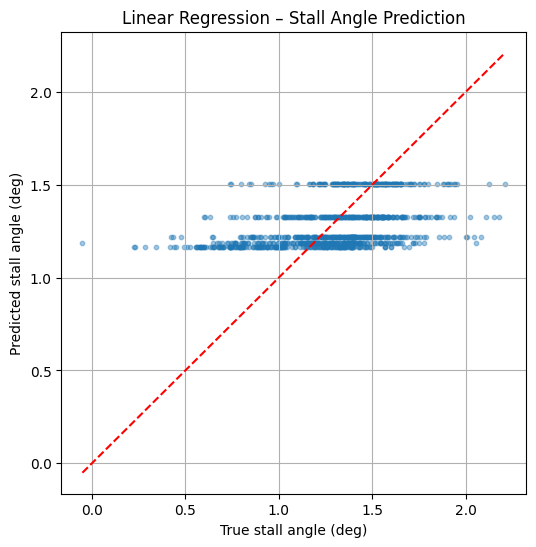

In [57]:
#Plot predicted vs true angle of stall
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, s=10, alpha=0.4)
min_v = min(y_val.min(), y_pred.min())
max_v = max(y_val.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--")
plt.xlabel("True stall angle (deg)")
plt.ylabel("Predicted stall angle (deg)")
plt.title("Linear Regression – Stall Angle Prediction")
plt.grid(True)
plt.show()


In [58]:
#Prediction Model (Optional to keep)
def predict_stall_angle_linear(
    model,
    Re: float,
    max_thickness: float,
    x_max_thickness: float,
    max_camber: float,
    x_max_camber: float,
    sharpness_rating: float,
    radius_rating: float,
) -> float:
    """
    Predict stall angle (deg) for a new airfoil using the trained linear model.
    """
    x_vec = np.array([[
        Re,
        max_thickness,
        x_max_thickness,
        max_camber,
        x_max_camber,
        sharpness_rating,
        radius_rating,
    ]], dtype=np.float32)
    return float(model.predict(x_vec)[0])

# Example usage:
example_alpha_stall = predict_stall_angle_linear(
    linreg,
    Re=1e6,
    max_thickness=0.12,
    x_max_thickness=0.30,
    max_camber=0.04,
    x_max_camber=0.40,
    sharpness_rating=80.0,
    radius_rating=20.0,
)
print("Predicted stall angle (deg):", example_alpha_stall)


Predicted stall angle (deg): 1.5045963525772095
